In [ ]:
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageEnhance
import random
import numpy as np

def modify_pixel(img,x,y,p1,p2):
    try:
        rdn = random.random()
        if rdn < p1:
            img.putpixel((x, y), 0)
        elif rdn < p2:
            img.putpixel((x, y), random.randint(220, 255))
        elif rdn > 1 - p2:
            img.putpixel((x, y), 0)
        return img
    except:
        pass
    

def salt_and_pepper(img,x,y,p1,p2,strength=0.5):
    rdn = strength*random.random()
    if rdn < p1:
        img.putpixel((x, y), random.randint(10,255))
    elif rdn < p2:
        img.putpixel((x, y), random.randint(220, 255))
    elif rdn > 1 - p2:
        img.putpixel((x, y), 255)


def transform_and_rotate_polygon(annotations, image_size, new_size, angle):
    """
    Transforms and rotates the polygon annotations after pasting and rotating.
    
    :param annotations: List of annotation dictionaries containing 'segmentation' key with polygon points.
    :param image_size: Tuple (width, height) of the original image.
    :param new_size: Tuple (new_width, new_height) of the new image after pasting.
    :param angle: Rotation angle in degrees (counterclockwise is positive).
    :return: List of transformed and rotated annotations.
    """
    original_width, original_height = image_size
    new_width, new_height = new_size
    
    # Compute translation due to pasting
    dx = (new_width - original_width) // 2
    dy = (new_height - original_height) // 2
    
    # Compute the center of rotation (center of new image)
    cx, cy = new_width // 2, new_height // 2
    
    # Convert angle to radians for rotation
    theta = np.radians(-angle)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    
    transformed_annotations = []
    
    for annot in annotations:
        points = annot['segmentation']
        new_points = []
        
        for i in range(0, len(points), 2):
            x, y = points[i], points[i+1]
            
            # Translate due to pasting
            x_new, y_new = x + dx, y + dy
            
            # Rotate around the center (cx, cy)
            x_rot = cos_theta * (x_new - cx) - sin_theta * (y_new - cy) + cx
            y_rot = sin_theta * (x_new - cx) + cos_theta * (y_new - cy) + cy
            
            new_points.extend([x_rot, y_rot])
        
        transformed_annotations.append({'segmentation': new_points})
    
    return transformed_annotations


def create_page(text:list,draw_info=False,get_annot=False):
    # Define constants
    fontsize = 25
    width = 1241
    height = 1754
    
    mt=-2
    mb=3
    
    annot=[]
    
    # Create a blank image with the specified width and height
    image = Image.new('L', (width, height), color='white')
    
    # Create a drawing object
    draw = ImageDraw.Draw(image)
    
    # Define text attributes
    font = ImageFont.truetype("TlwgTypewriter-Bold.ttf", size=fontsize)
    text_color = 0  # Black in grayscale

    position = (600, 60)
    header=f"- {str(random.randint(0,100))} -"
    draw.text(position, header, fill=text_color, font=font)
    if draw_info:
        draw.rectangle((596, 57, 598+15.6*len(header), 57+(fontsize+1)+4), outline=( 0))
    if get_annot:
        annot.append({'segmentation':[596,
                                      57,
                                      598+15.6*len(header),
                                      57,
                                      598+15.6*len(header),
                                      57+(fontsize+1)+4,
                                      596,
                                      57+(fontsize+1)+4
                     ]})
                      
    # Add text to the image
    for i,t in enumerate(text):
        position = (150, 130+(fontsize+1)*i)
        draw.text(position, t, fill=text_color, font=font)
        if len(t)>0:
            if draw_info:
                draw.text((100, 130+(fontsize+1)*i), str(i), fill=text_color, font=font)
                if len(t)<10:
                    draw.rectangle((146, 130+(fontsize+1)*i-mt, 148+15.6*len(t), 130+(fontsize+1)*(i+1)+mb), outline=( 0))
                else:
                    draw.rectangle((146, 130+(fontsize+1)*i-mt, 148+15.2*len(t), 130+(fontsize+1)*(i+1)+mb), outline=( 0))
        
            if get_annot:
                if len(t)<10:
                    annot.append({'segmentation':[146, 
                                                130+(fontsize+1)*i-mt, 
                                                148+15.6*len(t), 
                                                130+(fontsize+1)*i-mt,
                                                148+15.6*len(t), 
                                                130+(fontsize+1)*(i+1)+mb, 
                                                146,
                                                130+(fontsize+1)*(i+1)+mb]})
                else:
                    annot.append({'segmentation':[146, 
                                                130+(fontsize+1)*i-mt, 
                                                148+15.2*len(t), 
                                                130+(fontsize+1)*i-mt,
                                                148+15.2*len(t), 
                                                130+(fontsize+1)*(i+1)+mb, 
                                                146,
                                                130+(fontsize+1)*(i+1)+mb]})
        
    
    output = image.copy()
    p1,p2 = 0.1825, 0.10
    p3,p4 = 0.00825, 0.0510 
    
    # add salt and pepper
    for x in range(output.width-1):
        for y in range(output.height-1):
            if output.getpixel((x,y))==0:
                output=modify_pixel(output,x+1,y,p1,p2)
                output=modify_pixel(output,x-1,y,p1,p2)
                output=modify_pixel(output,x,y+1,p1,p2)
    
            else:   
                salt_and_pepper(output,x,y,p3,p4)    
    
   
    angle=0.8*np.random.normal()
    new_image=output
    
    curr_sharp=ImageEnhance.Sharpness(new_image)
    new_sharp=0.3
    im_sharped = curr_sharp.enhance(new_sharp)
    
    # Rotate the image by -5 degrees
    output = im_sharped.rotate(angle,Image.Resampling.NEAREST )
    
    # annot=transform_and_rotate_polygon(annot, (new_width,new_height), (width,height), angle)
    annot=transform_and_rotate_polygon(annot, (width,height), (width,height), angle)
    
    for line in annot:
        new_pts=[]
        for pts in line['segmentation']:
            new_pts.append(int(pts))
        line['segmentation']=new_pts
    
    return {
        "text": text,
        "image": output,
        "annotation":annot
    }

54


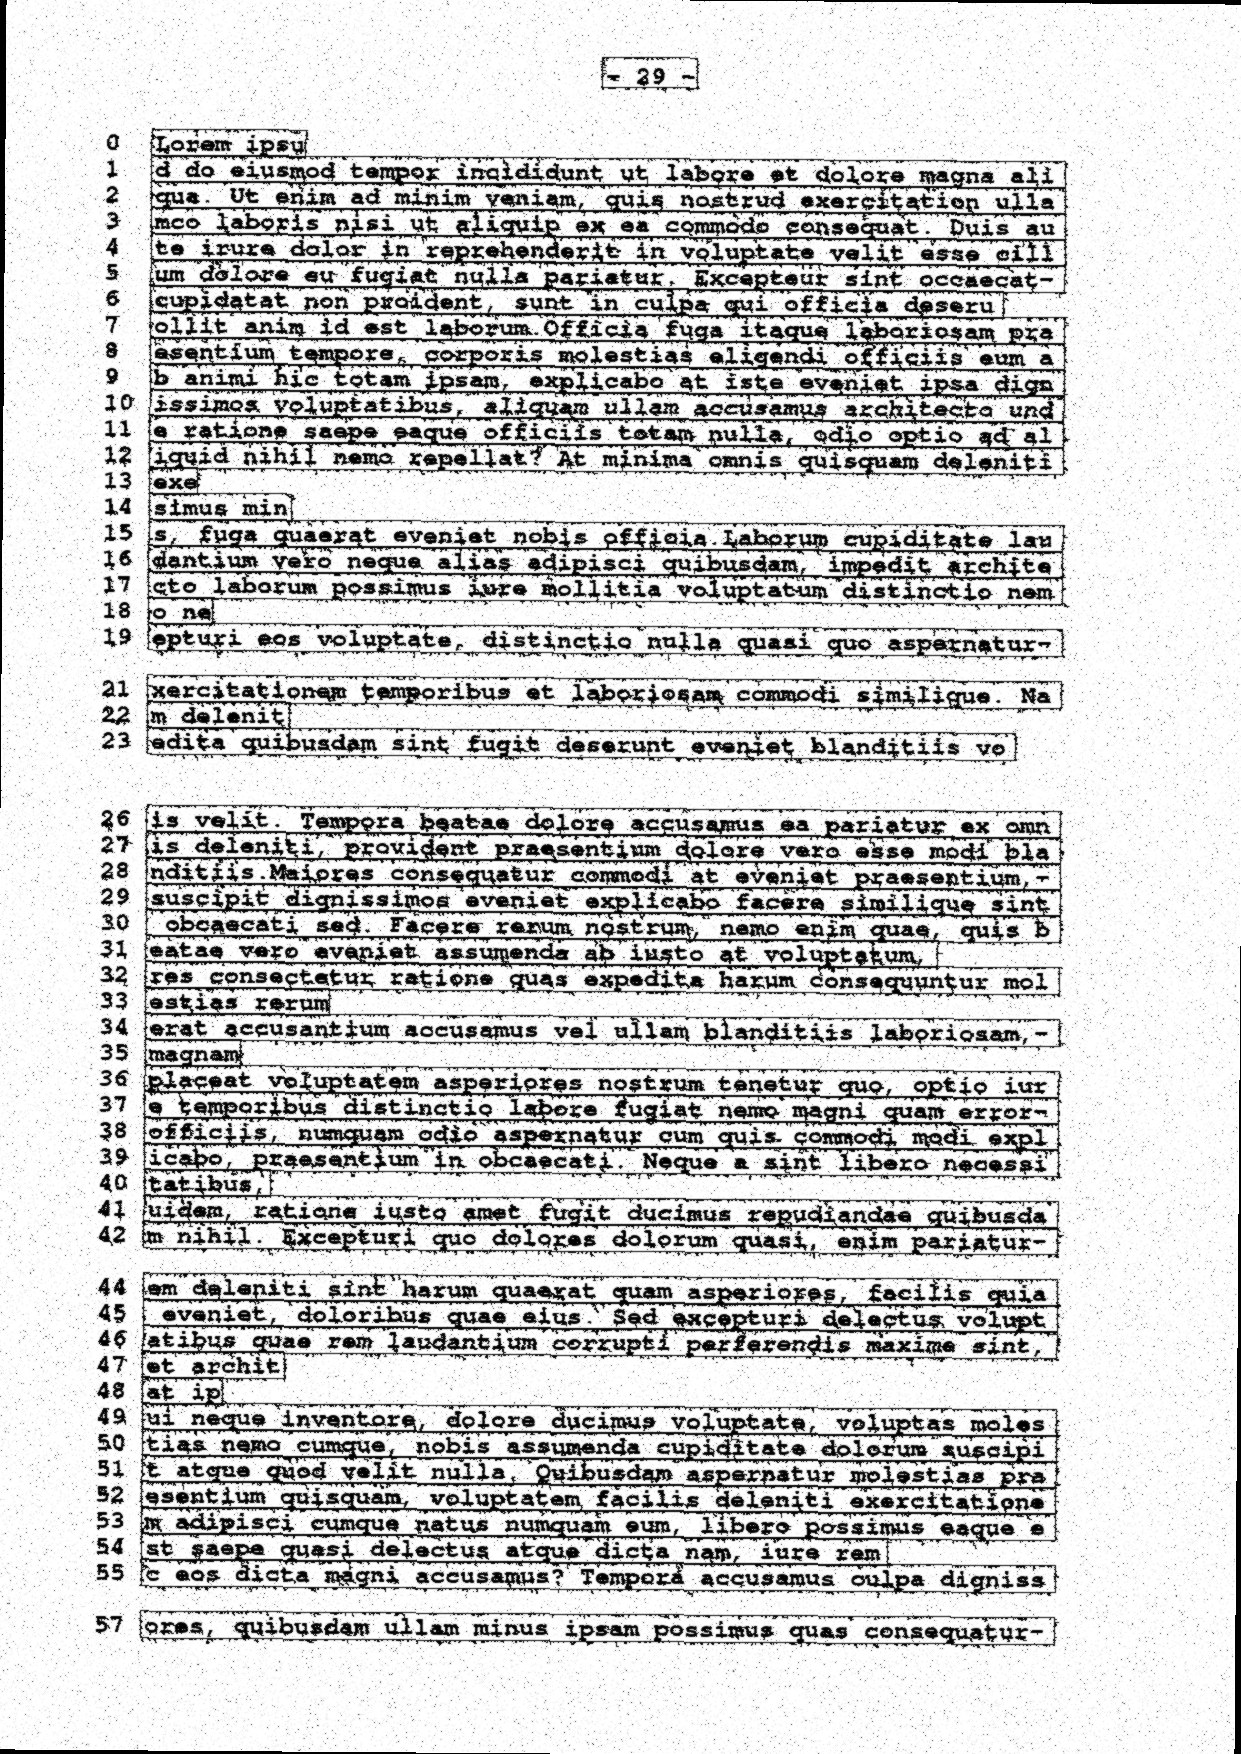

In [2]:
from lorem_text import lorem

paragraph_length = 7
par=lorem.paragraphs(paragraph_length)
len(par)

par= par.replace('\n','')

text=[]
nchar=60
for i in range(len(par)//nchar):
    line=par[:nchar]
    if line[-1]==" ":
        line=line[:-1]+"-"
    text.append(line)
    #print(line)
    par=par[nchar:]

p1=0.15
p2=0.85

for i in range(len(text)):
    rnd=random.random()
    if rnd<p1:
        text[i]=''
    if rnd>p2:
        text[i]=text[i][:random.randint(4,15)].strip()
    if rnd>p1 and rnd<2*p1:
        text[i]=text[i][:-random.randint(3,10)].strip()

    
len(text)
page=create_page(text[:59],draw_info=True,get_annot=True)
print(len(page['annotation']))
page['image']

In [3]:
from lorem_text import lorem

def create_text():
    paragraph_length = 7
    par=lorem.paragraphs(paragraph_length)
    len(par)

    par= par.replace('\n','')

    text=[]
    nchar=60
    for i in range(len(par)//nchar):
        line=par[:nchar]
        if line[-1]==" ":
            line=line[:-1]+"-"
        text.append(line)
        #print(line)
        par=par[nchar:]

    p1=0.15
    p2=0.85

    for i in range(len(text)):
        rnd=random.random()
        if rnd<p1:
            text[i]=''
        if rnd>p2:
            text[i]=text[i][:random.randint(4,15)].strip()
        if rnd>p1 and rnd<2*p1:
            text[i]=text[i][:-random.randint(3,10)].strip()
            
    return text


def compute_polygon_area(polygon):
    """
    Computes the area of a polygon using the Shoelace theorem.
    
    :param polygon: List of (x, y) coordinates defining the polygon.
    :return: Area of the polygon.
    """
    x = polygon[0::2]
    y = polygon[1::2]
    return 0.5 * abs(sum(x[i] * y[i+1] - x[i+1] * y[i] for i in range(-1, len(x)-1)))

def compute_bounding_box(polygon):
    """
    Computes the bounding box of a polygon.
    
    :param polygon: List of (x, y) coordinates defining the polygon.
    :return: Bounding box as (x_min, y_min, x_max, y_max).
    """
    x = polygon[0::2]
    y = polygon[1::2]
    return min(x), min(y), max(x), max(y)

In [4]:
pages=[]
for i in range(100):
    text=create_text()
    pages.append(create_page(text[:59],draw_info=False,get_annot=True))


In [ ]:
import os

data_dir="datasets/coco/images/train"
os.makedirs(data_dir,exist_ok=True)

data={'images':[],'annotations':[]}
nbimages,nbannots=0,0
n=0
for i,page in enumerate(pages):
    img=page['image']
    data['images'].append(
        {
            'id':nbimages+i+1,
            'width':img.size[0],
            'height':img.size[1],
            'file_name': f"synth_img_{i:02d}.jpg",
            'license':0,
            "date_captured": ""
        }
    )
    img.save(f"{data_dir}/synth_img_{i:02d}.jpg")
    for j,annot in enumerate(page['annotation']):
        print(n,i,j,annot['segmentation'])
        data['annotations'].append(
            {
                "segmentation":[annot['segmentation']],
                "area": int(compute_polygon_area(annot['segmentation'])),
                "bbox": list(compute_bounding_box(annot['segmentation'])),
                "iscrowd": 0,
                "id": nbannots+j+1,
                "image_id": nbimages+i+1,
                "category_id": 0                
            }
        )
        n+=1
        

0 0 0 [588, 57, 684, 56, 684, 86, 589, 87]
1 0 1 [139, 136, 1053, 128, 1053, 155, 139, 163]
2 0 2 [139, 162, 1053, 154, 1053, 181, 139, 189]
3 0 3 [139, 188, 235, 187, 235, 214, 140, 215]
4 0 4 [140, 214, 1054, 206, 1054, 233, 140, 241]
5 0 5 [140, 240, 267, 239, 267, 266, 140, 267]
6 0 6 [140, 266, 1054, 258, 1054, 285, 140, 293]
7 0 7 [140, 292, 1054, 284, 1055, 311, 141, 319]
8 0 8 [141, 344, 1055, 336, 1055, 363, 141, 371]
9 0 9 [141, 370, 1055, 362, 1055, 389, 141, 397]
10 0 10 [141, 396, 1055, 388, 1055, 415, 142, 423]
11 0 11 [142, 422, 237, 421, 237, 448, 142, 449]
12 0 12 [142, 448, 341, 446, 342, 473, 142, 475]
13 0 13 [142, 474, 1056, 466, 1056, 493, 142, 501]
14 0 14 [142, 500, 965, 492, 965, 519, 142, 527]
15 0 15 [142, 526, 312, 524, 312, 551, 143, 553]
16 0 16 [143, 552, 1057, 544, 1057, 571, 143, 579]
17 0 17 [143, 578, 1057, 570, 1057, 597, 143, 605]
18 0 18 [144, 656, 997, 648, 997, 675, 144, 683]
19 0 19 [144, 708, 1058, 700, 1058, 727, 144, 735]
20 0 20 [144, 734, 9

In [10]:
data['categories']=[
            {
            "supercategory": "type",
            "id": 0,
            "name": "line"
        }
]

In [ ]:
import json
with open("coco_dataset.json","w") as f:
    json.dump(data,f)

In [13]:
#!python COCO2YOLO-seg.py
!python COCO2YOLO-seg.py --json_file "coco_dataset.json" --output_folder "datasets/coco/labels/train"

Conversion completed. YOLO segmentation annotations saved in 'labels' folder.


In [ ]:
!git lfs install
!cd models && git clone https://huggingface.co/Riksarkivet/yolov9-lines-within-regions-1

Updated Git hooks.
Git LFS initialized.
Cloning into 'yolov9-lines-within-regions-1'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 28 (delta 11), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (28/28), 17.39 KiB | 2.17 MiB/s, done.


⚠️ troubleshouting: the next command depends on the setting.json config to be found in your `~/.config/Ultralytics` folder

you may have to adjust the `datasets_dir` attribute

In [18]:
!yolo segment train data=coco.yaml model=models/yolov9-lines-within-regions-1/model.pt epochs=5 imgsz=640 batch=8 project=outputs

Ultralytics 8.3.105 🚀 Python-3.11.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3080 Ti Laptop GPU, 16110MiB)
engine/trainer: task=segment, mode=train, model=models/yolov9-lines-within-regions-1/model.pt, data=coco.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=output, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru